# Section 1:光伏潜力预测图

## 美国案例区

In [2]:
from function import *
import pandas as pd
import pandas as pd
import geopandas as gpd
from typing import Sequence



abandon_2d_variable = [
    "current_abandonment",
    "recultivation", 
    "abandonment_duration",
    "abandonment_year"
]
fea_3d_variable = [
    'GDPpc',
    'GDPtot',   
    'GURdist',
    'Population',
    'gdmp',
    'rsds',
    'tas',
    'wind'
]
fea_2d_variable = [
    'DEM',
    'Powerdist',
    'PrimaryRoad',
    'SecondaryRoad',
    'Slope',
    'TertiaryRoad'
]
PATHS = {
    'abandonment': r"D:\xarray\merged_chunk_2\*.nc",
    'feature':     "D:/xarray/aligned2/Feature_all/*.nc",
    'csv':         "aligned_for_training0519.csv",
    'prediction':  "",
    'prediction_us': "",
    'test_output': "positive_samples_test_500.csv",
    'output':      "positive_samples_full_with_features.csv",
    'CN_sheng': r'data\sheng2022.shp',
    'World_shp': r'data\main_ADM_0.shp', 
    'us_abandon': r'data\us_abandon_clean.csv',
    'us_pv_embedding': r'data\training_embedding.csv'
}

ZERO_COLS = [
     'GDPpc', 'GDPtot', 'GURdist', 'Population',
    'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'gdmp'
]
YEARS = [2018, 2020]

NUMERIC_FEATURES = [
    'lat','lon','GDPpc', 'GDPtot', 'GURdist', 'DEM','Slope',
    'Population','Powerdist','PrimaryRoad','SecondaryRoad','TertiaryRoad',
    'gdmp','rsds','tas','wind'
]
CAT_COLS = ['landcover']

ABANDON_COLS = ['abandonment_year','abandonment_duration', 'current_abandonment']

NONE_ABANDON_COLS = ['recultivation']

time=['2018-01-01','2020-01-01']




You want to predict the year: 2020.0
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Other features:  []


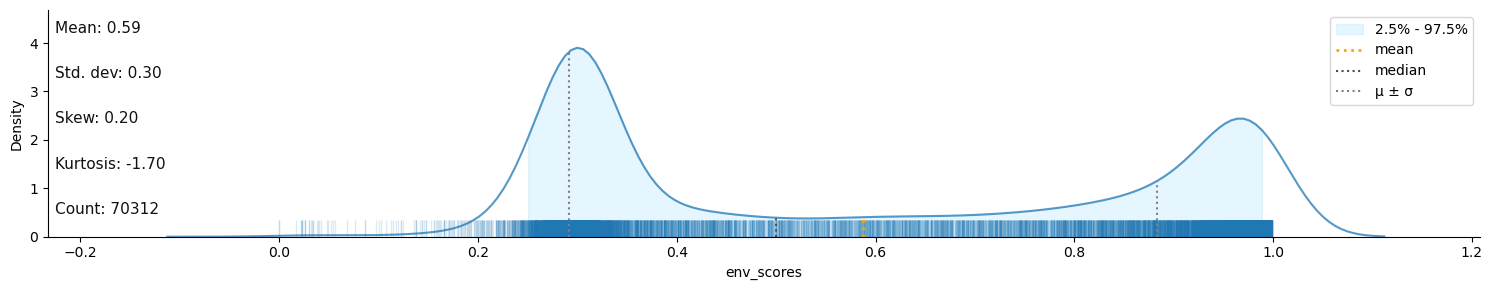

In [4]:
import geopandas as gpd
from function import *
from FeatureInsight import struct_Investigation,univar_dis,bivar_dis
import klib
import matplotlib.pyplot as plt
import pandas as pd

# Load world shapefile for boundaries
ds_abandon, ds_feat = load_datasets(PATHS['abandonment'],PATHS['feature'])

world = gpd.read_file(PATHS['World_shp'])
# Specify CRS when converting world shapefile
# world_bound = world.to_crs(epsg=4326)  # Using WGS 84 coordinate system

# Define USA mainland bounds
usa_bounds_main = {
    'lon_min': -125,  # Westernmost point (Washington state)
    'lon_max': -65,   # Easternmost point (Maine)
    'lat_min': 25,    # Southernmost point (Florida)
    'lat_max': 49     # Northernmost point (Canada border)
}

# Load data
us_df_abandon = load_abandon(PATHS['us_abandon'])
us_df_embedding = load_embedding(PATHS['us_pv_embedding'])

# Filter data to USA mainland bounds
us_df_embedding = us_df_embedding[
    (us_df_embedding['lon'] >= usa_bounds_main['lon_min']) & 
    (us_df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (us_df_embedding['lat'] >= usa_bounds_main['lat_min']) & 
    (us_df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

us_df_embedding_fill = fill_nonpositive_with_nearest(us_df_embedding)

us_df_abandon_filtered = pd.read_csv('./data/abandon_filtered_with_scores.csv')
df_scores = pd.DataFrame(us_df_abandon_filtered['env_scores'])
univar_dis(df_scores, df_scores.columns)



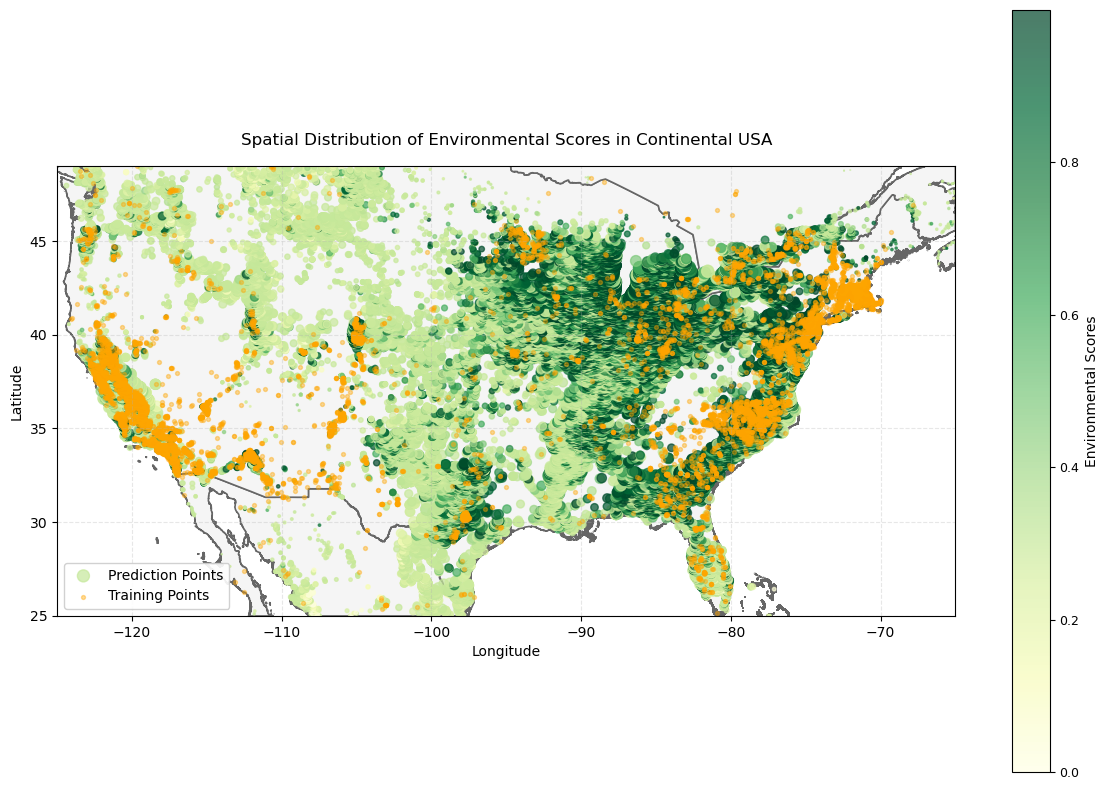

In [11]:
import geopandas as gpd
from function import *
from FeatureInsight import struct_Investigation,univar_dis,bivar_dis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde

# Create figure and set size
fig, ax = plt.subplots(figsize=(12,8))

# Define USA mainland bounds
usa_bounds_main = {
        'lon_min': -125,  # Westernmost point (Washington state)
        'lon_max': -65,   # Easternmost point (Maine)
        'lat_min': 25,    # Southernmost point (Florida)
        'lat_max': 49     # Northernmost point (Canada border)
    }
bbox = box(usa_bounds_main['lon_min'], 
          usa_bounds_main['lat_min'], 
          usa_bounds_main['lon_max'], 
          usa_bounds_main['lat_max'])

world = gpd.read_file(PATHS['World_shp'])
us_main = world.clip(bbox)

# Set plot bounds to USA mainland
ax.set_xlim(usa_bounds_main['lon_min'], usa_bounds_main['lon_max'])
ax.set_ylim(usa_bounds_main['lat_min'], usa_bounds_main['lat_max'])

# Draw USA mainland base map with more prominent borders
us_main.plot(ax=ax, color='#f5f5f5', edgecolor='#666666', linewidth=1.2)

# Create YlGn colormap for prediction points
pred_colors = plt.cm.YlGn(np.linspace(0, 1, 256))
pred_cmap = ListedColormap(pred_colors)

# Create gradient colormap for training points (orange)
train_colors = np.array(['#fff2e6', '#ffd9b3', '#ffbf80', '#ffa64d', '#ff8c1a'])  # Light to dark orange
rgb_train_colors = np.linspace(plt.matplotlib.colors.to_rgb(train_colors[0]), 
                        plt.matplotlib.colors.to_rgb(train_colors[-1]), 
                        256)
train_cmap = ListedColormap(rgb_train_colors)

# Calculate point density for clustering
xy_coords = np.vstack([us_df_abandon_filtered['lon'], us_df_abandon_filtered['lat']])
z = gaussian_kde(xy_coords)(xy_coords)

# Plot prediction points with size based on density
scatter = ax.scatter(us_df_abandon_filtered['lon'], us_df_abandon_filtered['lat'],
                    c=us_df_abandon_filtered['env_scores'],
                    s=150 * z/z.max(),  # Increased size multiplier from 100 to 150
                    cmap=pred_cmap,
                    alpha=0.7,
                    label='Prediction Points')

# Plot training points with smaller size
train_scatter = ax.scatter(us_df_embedding_fill['lon'], us_df_embedding_fill['lat'],
                          alpha=0.4, s=8, c='orange',  # Reduced size from 15 to 8
                          label='Training Points')

# Add colorbar
cbar = plt.colorbar(scatter, label='Environmental Scores', ax=ax)
cbar.ax.tick_params(labelsize=9)

# Set chart style
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)
ax.set_title('Spatial Distribution of Environmental Scores in Continental USA', 
             fontsize=12, pad=15)
ax.legend(frameon=True, facecolor='white', framealpha=0.9)
ax.grid(True, linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()